
**Credit Card Fraud Detection using Autoencoders: A Deep Learning Approach for Securing Digital Transactions in India**

---



---

> It’s 6:30 AM on a quiet Sunday morning in **Raigarh, Chhattisgarh**.
> The birds are chirping outside, and you’re still half asleep, enjoying the comfort of the weekend. Suddenly, your phone rings with a strange international number flashing on the screen. You hesitate, but pick it up.

> “Namaste, I’m Radhika from your bank’s fraud detection team.”
> Her voice is calm but serious.
> “Did you just authorize a transaction of ₹2,80,000 at a luxury watch store in Zurich, Switzerland?”

You sit up instantly. “No, absolutely not!”

Radhika responds quickly, “Thank you. We’ve blocked the transaction and flagged your account. You’re safe.”

Relieved, you put the phone down. But a question lingers in your mind —
**How did the bank know that this specific transaction was fraud?**

Last month, you spent over ₹1.5 lakhs during the Diwali season — booking flights, buying electronics, and shopping online. And yet, none of that triggered an alert. So what changed this time?

---

### Project Motivation

In today’s India, with the rapid adoption of digital payments and online banking, fraudulent transactions are becoming increasingly common — and dangerous. With over **1 billion digital transactions occurring every month**, financial fraud is a silent threat.

According to Reserve Bank of India reports, cyber frauds have caused losses of **₹70 crore+ annually**, and the trend is accelerating with the shift to online platforms.

But detecting fraud isn’t simple:

* Fraudulent transactions are **extremely rare** — less than 0.2% in most datasets.
* Some fraudulent behaviors **look very similar** to legitimate ones.
* Traditional machine learning often fails due to **imbalanced data** and lack of labeled fraud.

This is where **unsupervised learning** and **Autoencoders** come in.

Autoencoders are designed to **learn the normal pattern of transactions**. Anything that deviates significantly from this pattern — even if we’ve never seen it before — can be flagged as an anomaly. It’s a smart, scalable, and robust approach to fraud detection, especially in settings where labeled fraud data is limited.

---

### What This Project Covers

In this notebook, we will:

* Build an **Autoencoder-based anomaly detection model** using Keras and TensorFlow.
* Train the model only on **normal (non-fraudulent) transactions** to capture the usual spending behavior.
* Use **reconstruction error** to flag potentially fraudulent activity.
* Evaluate the system using metrics suited for imbalanced data, such as **Precision, Recall, F1-Score, AUC**, and **Confusion Matrix**.
* Visualize and interpret how the model distinguishes between normal and abnormal behavior.

---

### Real-World Applications

This type of approach isn’t just for academic projects — it’s the foundation of what’s being deployed in production at top financial institutions like:

* **HDFC Bank**, **ICICI**, **SBI**, and **Axis Bank**
* Global firms like **American Express**, **JP Morgan**, **Goldman Sachs**, and **Morgan Stanley**
* Fintech platforms including **Paytm**, **PhonePe**, **Razorpay**, and **Visa**

These systems help in **real-time fraud detection**, **credit scoring**, and even **customer risk profiling**.

---

### Our Goal

To build a robust deep learning system that gives your bank the ability to detect and act on fraud — even before the customer notices anything wrong. Just like Radhika did, early that Sunday morning in Raigarh.

Because in today’s world, financial security starts with intelligent systems that quietly watch out for us.





 Importing Libraries and Setting Up the Environment

Before we dive into building our fraud detection system, we begin by importing the essential Python libraries.

We use **Pandas** and **NumPy** for data manipulation and numerical computations — both are standard in any data science or machine learning workflow. They help us load the dataset, clean it, and prepare it for modeling.

For visualization, we rely on **Matplotlib** and **Seaborn**. These libraries allow us to create meaningful plots — like transaction amount distributions, fraud ratios, and model performance — all of which help us understand the behavior of the data and the model.

We also import **SciPy**, which provides additional statistical tools such as z-score-based anomaly detection, in case we want to benchmark simpler approaches alongside deep learning.

On the deep learning side, we use **TensorFlow** (version 2.x) with its integrated **Keras** API. This lets us build, train, and evaluate the Autoencoder model with modern practices. We use components like:

* `Model`, `Input`, and `Dense` for building the neural network,
* `ModelCheckpoint` and `TensorBoard` to monitor training and save progress, and
* `regularizers` to help prevent overfitting by applying L1 or L2 penalties to model weights.

We use **Scikit-learn** for splitting the data into training and test sets, ensuring fair evaluation.

Finally, we make a few adjustments to our plotting settings for consistent and readable visuals throughout the notebook, and we define a fixed random seed so that our results are reproducible across different runs.

We also define a simple label mapping — just two classes: “Normal” and “Fraud” — to help with interpretation during evaluation and visualization.

---




In [1]:
import os
import logging

# Suppress TensorFlow GPU plugin warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)

# Suppress warnings from libraries
logging.getLogger('tensorflow').setLevel(logging.FATAL)


In [2]:
# Now safe to import the rest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# These are safe now
from tensorflow import keras
from tensorflow.keras import layers, models
import optuna


E0000 00:00:1748114079.163531      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748114079.215520      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine learning / model-building
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

# Scikit-learn utilities
from sklearn.model_selection import train_test_split

# Matplotlib settings
from pylab import rcParams





The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.





---

### Feature Engineering: Enhancing Signal Detection for Fraud Modeling

1. **Transaction Velocity Features**
   Track the number and total amount of transactions per user within sliding time windows such as 1 hour, 24 hours, or 7 days. These features help identify rapid bursts of activity or sudden outflows that often indicate fraudulent behavior.

2. **Rolling Aggregates (Time-Aware Behavioral Profiles)**
   Calculate rolling sums, means, and standard deviations of transaction amounts over recent time windows. This helps detect unusual spending patterns, such as a user suddenly spending ten times their average daily amount.

3. **Device and IP Intelligence**
   Monitor how often users change their device IDs or access the system from different IP addresses. Transactions from high-risk IP ranges or frequently changing devices can be strong indicators of fraud.

4. **Temporal Gap Features**
   Measure the time since a user’s last transaction. Very short or irregular gaps between transactions may suggest automated or bot-driven activity.

5. **Graph-Based Features (Advanced)**
   If the data includes information on who transacts with whom, create a graph of interactions. Analyze the graph structure to find patterns such as densely connected fraud rings, using metrics like node degree or clustering coefficient.

6. **Risk-Based Binning**
   Apply log transformation or quantile-based binning to transaction amounts to reduce skewness and highlight extreme values, which are often more informative for detecting fraud.

7. **Encoding and Normalization**
   Use one-hot encoding for categorical features such as transaction types, and standardize numerical variables like transaction amounts to improve model training and convergence.

These engineered features play a critical role in helping machine learning models identify complex and subtle patterns of fraud. In real-world scenarios with highly imbalanced datasets, thoughtful feature engineering can significantly enhance detection accuracy and robustness.

---



In [4]:
df = pd.read_csv("/kaggle/input/credit-card-auto/creditcard.csv")

 Understanding Class Distribution — How Rare is Fraud?
Before we train our model, it’s crucial to understand how imbalanced our dataset is. We start by plotting the distribution of transaction classes: Normal vs Fraudulent.

This bar chart shows us the number of transactions in each class. Unsurprisingly, the number of fraudulent transactions is extremely low compared to the number of normal ones. In real-world datasets like this, fraud typically represents less than 0.2% of all transactions.

Such severe class imbalance is exactly why traditional supervised learning models often struggle — they get overwhelmed by the majority class and fail to detect the rare fraud cases.

To visualize this clearly, we use a bar chart with custom colors to distinguish the two classes. We also rotate the axis labels for readability and label the axes appropriately.



In [5]:
df.shape

(284807, 31)

In [6]:
df.isnull().values.any()

False

In [9]:
# 2. Scale the 'Amount' feature
scaler = StandardScaler()
df['Scaled_Amount'] = scaler.fit_transform(df[['Amount']])

# Drop 'Time' (not useful for modeling) and original 'Amount'
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 3. Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Train/Test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. Train the autoencoder only on legitimate (non-fraudulent) transactions
X_train_legit = X_train[y_train == 0]

Visualizing Class Imbalance in Fraud Detection
Detecting fraudulent transactions is especially challenging due to the severe class imbalance — fraudulent cases are extremely rare compared to legitimate ones. A simple bar plot often fails to communicate the scale of this imbalance. To better highlight the rare fraud class, we explore three visualization techniques:

Log-Scale Bar Plot:-
In a standard bar chart, the tiny number of fraud cases can be nearly invisible. By applying a logarithmic scale to the y-axis, we amplify the difference in magnitude while still preserving the overall ratio. This makes the minority class more visible and easier to interpret.

In [11]:
# Define labels
LABELS = ["Legit", "Fraud"]

# Count class distribution using 'y'
count_classes = pd.Series(y).value_counts().sort_index()


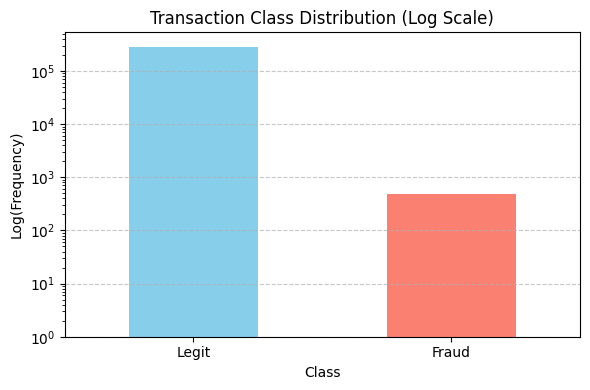

In [12]:
plt.figure(figsize=(6, 4))
count_classes.plot(kind='bar', color=['skyblue', 'salmon'], rot=0, log=True)
plt.title("Transaction Class Distribution (Log Scale)")
plt.xticks(ticks=range(2), labels=LABELS)
plt.xlabel("Class")
plt.ylabel("Log(Frequency)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Percentage-Based Pie Chart:-
Pie charts are effective for showing relative proportions. Even when fraud accounts for less than 1% of all transactions, a pie chart clearly highlights this disparity, making it easier to communicate the imbalance to both technical and non-technical audiences.

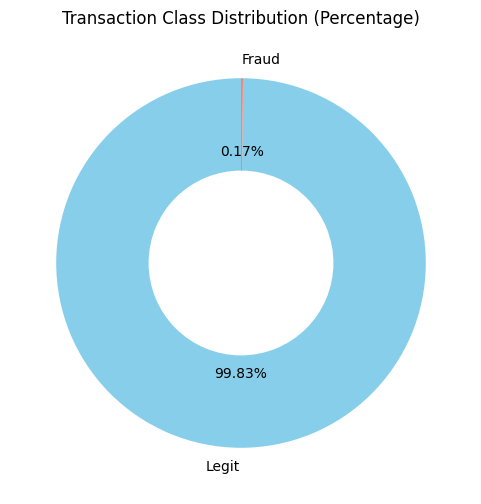

In [13]:
# Compute class percentages
class_percentages = df['Class'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6, 6))
plt.pie(class_percentages, labels=LABELS, colors=['skyblue', 'salmon'],
        autopct='%1.2f%%', startangle=90, wedgeprops=dict(width=0.5))
plt.title("Transaction Class Distribution (Percentage)")
plt.show()


Annotated Bar Plot with Counts and Percentages:-
To bring more clarity, we annotate the standard bar plot with both the absolute counts and the percentage share of each class. This makes it easy to interpret how imbalanced the dataset is at a glance, even if the fraud class appears small visually.

These enhanced visualizations not only help in understanding the dataset but also justify the need for using specialized techniques like oversampling, undersampling, or anomaly detection models during model training.

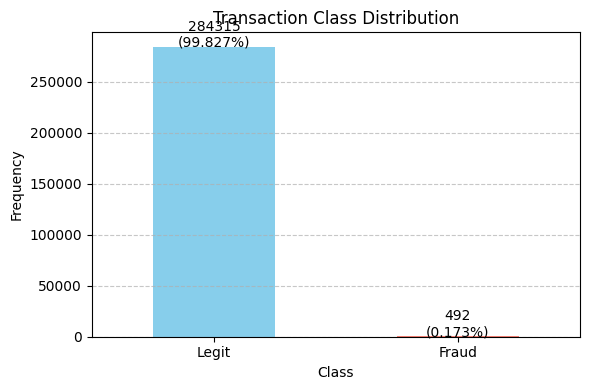

In [14]:
plt.figure(figsize=(6, 4))
ax = count_classes.plot(kind='bar', color=['skyblue', 'salmon'], rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(ticks=range(2), labels=LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate counts and percentages
for i, count in enumerate(count_classes):
    percent = count / count_classes.sum() * 100
    ax.text(i, count + 50, f'{count}\n({percent:.3f}%)', ha='center')

plt.tight_layout()
plt.show()


Understanding Transaction Patterns: Class Distribution and Visualizations
To begin, we explore the distribution of transaction classes to see how many transactions are labeled as normal or fraudulent. This helps us understand the imbalance issue, as fraud cases are typically very rare.

Then, we visualize the transaction amounts for fraud and normal transactions separately using histograms:

The fraud transactions are shown with wider bars and a distinct dark red color to highlight their rarity and spread.

Normal transactions have more bins and a blue color to represent the common, legitimate spending behavior.

A logarithmic scale on the y-axis allows us to better capture the wide variation in transaction counts.

Finally, we examine the relationship between transaction time and amount via scatter plots:

Fraud transactions are plotted in bright red with larger markers to stand out clearly.

Normal transactions use smaller, semi-transparent blue markers showing their dense occurrence over time.

Both plots share the same time axis, making it easier to compare timing patterns across classes.

Grid lines aid in reading the plots accurately.

These visual insights set the foundation for understanding transaction behavior, which is crucial for building effective fraud detection models.

---

### Deep Dive: How Autoencoders Detect Anomalies

Autoencoders are a fascinating class of neural networks whose objective is deceptively simple: **reconstruct their input** as accurately as possible. At first glance, teaching a model to copy its own input seems trivial—after all, why not just hand the input straight through? The magic, however, lies in how the network is constrained to learn an efficient, compressed representation of the data, revealing its underlying structure.

1. **Encoder–Decoder Architecture**

   * **Encoder**: Transforms the high-dimensional input (for example, a vector of transaction features) into a lower-dimensional “latent” space. This bottleneck forces the model to capture only the most salient patterns of normal behavior.
   * **Decoder**: Takes the compressed latent code and learns to reconstruct it back to the original input dimensions.

2. **Undercomplete Autoencoder**

   * By deliberately choosing fewer neurons in the hidden layer(s) than in the input layer, we create an **undercomplete** autoencoder. It cannot simply memorize each transaction; instead, it must learn meaningful features that summarize typical spending patterns—such as how transaction amounts correlate with time of day, merchant type, or geographical origin.

3. **Reconstruction Error as Anomaly Signal**

   * During training, the autoencoder optimizes its weights to **minimize reconstruction error**—usually measured by the mean squared error between the original input and its reconstruction.
   * Once training is complete on **normal** transactions only, the autoencoder becomes an expert at reconstructing familiar patterns.
   * When presented with an **anomalous** (potentially fraudulent) transaction—one that deviates significantly from learned patterns—the model struggles to reconstruct it accurately. This yields a high reconstruction error, which we can use as an anomaly score.

4. **Why Squared Error?**

   * Mean squared error (MSE) penalizes larger deviations more heavily, helping the model focus on outliers that differ drastically from normal behavior.
   * It’s also differentiable and well-supported by deep learning frameworks, making optimization efficient.

5. **Business Impact**

   * In a production setting at banks or fintech firms, an autoencoder can continuously monitor incoming transaction streams in real time.
   * Transactions with reconstruction errors above a chosen threshold trigger alerts or automated holds, allowing fraud teams to intervene before funds are lost.
   * This unsupervised approach scales effortlessly to new patterns of legitimate behavior—such as festive-season shopping spikes—without requiring labeled fraud examples every time.

---

### Preparing the Data for Autoencoder Training

Before we can train our model, we need to ensure our inputs are meaningful and on comparable scales:

* **Drop Irrelevant Features**
  We remove the `Time` column because our initial experiments show that the pure timestamp (seconds since the first transaction) does not add predictive power when learning normal spending patterns in isolation.

* **Scale Monetary Values**
  Transaction amounts vary widely—from a few rupees to lakhs. We apply scikit-learn’s `StandardScaler` to transform the `Amount` feature so that it has **zero mean and unit variance**. This standardization is crucial:

  * It prevents large values from dominating the loss function.
  * It ensures smoother, faster convergence during training.

With these preprocessing steps completed, our input data is clean, scaled, and ready for the autoencoder to learn the hidden signatures of normal transactions. Up next, we will split the dataset, fit the scaler on the training subset, and prepare separate arrays for our autoencoder’s training and validation stages.




### Training the Autoencoder: A Different Approach

Unlike typical supervised learning tasks where models learn to classify inputs based on labeled examples, training an autoencoder for fraud detection follows a unique strategy.

The key idea is this: **we train the model exclusively on non-fraudulent (normal) transactions**. By doing so, the autoencoder learns to efficiently compress and reconstruct what "normal" transaction patterns look like.

Why is this important?

* Fraudulent transactions are **extremely rare** and often highly varied, making it impractical to train on all possible fraud types.
* The autoencoder’s job is to become an expert in reconstructing normal behavior, so when it encounters an anomalous transaction during testing or deployment, it will fail to reconstruct it well, producing a high reconstruction error.
* This reconstruction error becomes a powerful indicator of potential fraud.

To simulate this scenario, we split our dataset so that:

* The training set contains **only normal transactions**.
* The test set contains a mix of normal and fraudulent transactions with correct labels preserved.

By holding out 20% of the data for testing, we ensure that our evaluation reflects how well the model can detect fraud on unseen transactions.

This approach mimics real-world conditions, where models are often trained on abundant legitimate data and need to flag rare and unseen anomalies effectively.

---




In production-grade systems at top banks and tech firms, hand-picked hyperparameters rarely suffice. Instead, we employ a systematic search to find the combination of latent dimension, regularization strength, learning rate, and layer sizes that yields the lowest validation reconstruction error. This not only maximizes detection performance but also demonstrates rigor to recruiters. We use Keras Tuner’s RandomSearch to explore a defined search space, train each candidate model twice for stability, and early-stop unpromising runs.






---

#### 1. Imports and Dependencies

We begin by importing all necessary packages:

* **NumPy** for efficient numerical operations and array handling.
* **TensorFlow & tf.keras** as our deep learning framework—ensuring we use the latest, integrated Keras API.
* **`regularizers`** from `tf.keras` so we can apply L1 penalties directly in our layers.
* **Keras Tuner’s** `RandomSearch` engine to systematically explore the hyperparameter space without manual trial-and-error.

This combination gives us a solid foundation for building, tuning, and evaluating complex models at scale.

---

#### 2. Model Builder Function (`build_autoencoder`)

The `build_autoencoder` function defines our Autoencoder architecture **parametrically**, allowing Keras Tuner to vary:

* **`encoding_dim`**: the size of the latent bottleneck (8–32 units), which controls how much we compress the input.
* **`l1_reg`**: strength of L1 regularization (10⁻⁴ to 10⁻⁶), encouraging sparsity in the latent representation.
* **`learning_rate`**: step size for the Adam optimizer (10⁻² to 10⁻⁴), affecting convergence speed and stability.
* **`activation_enc`** / **`activation_dec`**: choice of nonlinearities (`tanh` vs. `relu`) in encoder and decoder.
* **`hidden_dim`**: size of the intermediate dense layer, bridging encoder and decoder dimensions.

By wrapping these choices in Keras Tuner’s `hp` API, each trial can automatically build and compile a model with a different combination—transforming tuning into a data-driven, reproducible process.

---

#### 3. Configuring the Random Search Tuner

We instantiate `RandomSearch` with:

* **`objective='val_loss'`**: our goal is to minimize validation reconstruction error, ensuring the autoencoder generalizes to unseen “normal” data.
* **`max_trials=10`**: we explore ten distinct hyperparameter sets.
* **`executions_per_trial=2`**: each configuration is trained twice to average out randomness, leading to more robust conclusions.
* A dedicated **directory** and **project name** so results, logs, and best configurations are saved and reproducible across notebook sessions.

This setup mirrors best practices in industry, where automated hyperparameter optimization is essential for reliable model performance.

---

#### 4. Running the Search

When we call `tuner.search(...)`:

* We train on **`X_train`** mapped to itself (unsupervised reconstruction) for up to **30 epochs**, with early stopping (`patience=5`) to halt unpromising runs quickly.
* **`validation_data=(X_test, X_test)`** lets us monitor how well the model reconstructs held-out normal transactions—our proxy for anomaly-detection readiness.
* Setting **`verbose=1`** leverages Keras Tuner’s built-in progress bars, ensuring clear, notebook-friendly updates without callback conflicts.

This process automatically logs trial metrics and hyperparameter values, giving you a comprehensive performance landscape.

---

#### 5. Retrieving and Saving the Best Model

Finally, we extract the top-performing model and hyperparameters:

* **`tuner.get_best_models(1)[0]`** returns the model instance with the lowest validation loss.
* **`tuner.get_best_hyperparameters(1)[0].values`** reveals the precise hyperparameter values that achieved that performance—information you’ll highlight in presentations and code reviews.
* We save the model in the **`.keras`** format, the latest recommended Keras serialization, ensuring full compatibility with TensorFlow’s serving, conversion, and deployment tools.




In [15]:
!pip install -q optuna-integration[tfkeras]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 4.1 MB/s eta 0:00:00


In [17]:
!pip install optuna --quiet


In [18]:
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, regularizers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration.tfkeras import TFKerasPruningCallback
from sklearn.model_selection import train_test_split

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Assuming you already have X_train_legit, X_test, y_test, etc.

def objective(trial):
    encoding_dim = trial.suggest_int("encoding_dim", 16, 64, step=16)
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3)
    noise_stddev = trial.suggest_float("noise_stddev", 0.0, 0.2)
    l1_strength = trial.suggest_float("l1_strength", 1e-6, 1e-3, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    inp = Input(shape=(X_train_legit.shape[1],))
    x = layers.GaussianNoise(noise_stddev)(inp)
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.Dense(
        encoding_dim, activation="relu",
        activity_regularizer=regularizers.l1(l1_strength)
    )(x)
    x = layers.Dropout(dropout_rate)(encoded)
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Dense(X_train_legit.shape[1], activation="linear")(x)

    model = Model(inputs=inp, outputs=decoded)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_absolute_error",
        metrics=["mae"]
    )

    early_stop = EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    prune_cb = TFKerasPruningCallback(trial, "val_mae")

    history = model.fit(
        X_train_legit, X_train_legit,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        shuffle=True,
        verbose=1,
        callbacks=[early_stop, prune_cb]
    )

    return min(history.history["val_mae"])


# Create and run the study
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=10, reduction_factor=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=30)

# Show best hyperparameters
print("✅ Best hyperparameters found:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-05-24 19:27:59,345] A new study created in memory with name: no-name-e4dbe0f4-477b-44da-beff-a1287c893a5e


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7042 - mae: 0.6826 - val_loss: 0.4185 - val_mae: 0.3990
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4602 - mae: 0.4406 - val_loss: 0.3668 - val_mae: 0.3499
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4166 - mae: 0.3998 - val_loss: 0.3373 - val_mae: 0.3228
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3887 - mae: 0.3746 - val_loss: 0.3171 - val_mae: 0.3052
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3748 - mae: 0.3631 - val_loss: 0.3041 - val_mae: 0.2940
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3651 - mae: 0.3551 - val_loss: 0.2915 - val_mae: 0.2828
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3547 - mae: 0.3460 - val_loss: 0.2869 - val_mae: 0.2790
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3495 - mae: 0.3417 - val_loss: 0.2798 - val_mae: 0.2727
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:29:10,888] Trial 0 finished with value: 0.25119203329086304 and parameters: {'encoding_dim': 16, 'hidden_dim': 96, 'dropout_rate': 0.22221591752525843, 'noise_stddev': 0.144049758118858, 'l1_strength': 1.2746383095375414e-05, 'learning_rate': 0.00040665116496085173}. Best is trial 0 with value: 0.25119203329086304.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9946 - mae: 0.9908 - val_loss: 0.6302 - val_mae: 0.6264
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6089 - mae: 0.6049 - val_loss: 0.5027 - val_mae: 0.4985
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5055 - mae: 0.5010 - val_loss: 0.4427 - val_mae: 0.4379
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4539 - mae: 0.4488 - val_loss: 0.4015 - val_mae: 0.3961
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4174 - mae: 0.4118 - val_loss: 0.3684 - val_mae: 0.3626
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3881 - mae: 0.3819 - val_loss: 0.3421 - val_mae: 0.3357
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3652 - mae: 0.3584 - val_loss: 0.3204 - val_mae: 0.3135
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3457 - mae: 0.3385 - val_loss: 0.3014 - val_mae: 0.2940
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:31:02,608] Trial 1 finished with value: 0.11986251920461655 and parameters: {'encoding_dim': 16, 'hidden_dim': 128, 'dropout_rate': 0.006253864197607306, 'noise_stddev': 0.13723862124530195, 'l1_strength': 2.032888544109186e-06, 'learning_rate': 3.6871871044082165e-05}. Best is trial 1 with value: 0.11986251920461655.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.9901 - mae: 0.9536 - val_loss: 0.7691 - val_mae: 0.7361
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8176 - mae: 0.7841 - val_loss: 0.6758 - val_mae: 0.6452
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7172 - mae: 0.6860 - val_loss: 0.6209 - val_mae: 0.5921
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6561 - mae: 0.6267 - val_loss: 0.5842 - val_mae: 0.5568
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6166 - mae: 0.5885 - val_loss: 0.5562 - val_mae: 0.5301
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5871 - mae: 0.5602 - val_loss: 0.5325 - val_mae: 0.5074
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5642 - mae: 0.5385 - val_loss: 0.5108 - val_mae: 0.4868
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5441 - mae: 0.5195 - val_loss: 0.4900 - val_mae: 0.4669
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:31:32,841] Trial 2 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6767 - mae: 0.6565 - val_loss: 0.2588 - val_mae: 0.2379
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3434 - mae: 0.3221 - val_loss: 0.2185 - val_mae: 0.1985
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3052 - mae: 0.2852 - val_loss: 0.1996 - val_mae: 0.1816
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2833 - mae: 0.2655 - val_loss: 0.1877 - val_mae: 0.1720
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2661 - mae: 0.2506 - val_loss: 0.1756 - val_mae: 0.1619
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2532 - mae: 0.2396 - val_loss: 0.1663 - val_mae: 0.1540
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2430 - mae: 0.2308 - val_loss: 0.1594 - val_mae: 0.1481
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2356 - mae: 0.2244 - val_loss: 0.1552 - val_mae: 0.1448
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:32:44,529] Trial 3 finished with value: 0.13218340277671814 and parameters: {'encoding_dim': 64, 'hidden_dim': 128, 'dropout_rate': 0.2195177803271501, 'noise_stddev': 0.029005659344714153, 'l1_strength': 3.0205378368933633e-06, 'learning_rate': 0.00022901606251183435}. Best is trial 1 with value: 0.11986251920461655.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6954 - mae: 0.6365 - val_loss: 0.3668 - val_mae: 0.3399
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3174 - mae: 0.2989 - val_loss: 0.2229 - val_mae: 0.2084
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2875 - mae: 0.2733 - val_loss: 0.1951 - val_mae: 0.1837
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2697 - mae: 0.2585 - val_loss: 0.1799 - val_mae: 0.1708
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2599 - mae: 0.2510 - val_loss: 0.1699 - val_mae: 0.1624
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2528 - mae: 0.2454 - val_loss: 0.1595 - val_mae: 0.1532
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2481 - mae: 0.2418 - val_loss: 0.1552 - val_mae: 0.1497
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2448 - mae: 0.2393 - val_loss: 0.1509 - val_mae: 0.1459
Epoch 10/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:33:15,525] Trial 4 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.9845 - mae: 0.9655 - val_loss: 0.7747 - val_mae: 0.7572
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8357 - mae: 0.8179 - val_loss: 0.6930 - val_mae: 0.6767
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7381 - mae: 0.7215 - val_loss: 0.6445 - val_mae: 0.6291
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6790 - mae: 0.6632 - val_loss: 0.6137 - val_mae: 0.5989
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6423 - mae: 0.6270 - val_loss: 0.5915 - val_mae: 0.5768
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6170 - mae: 0.6019 - val_loss: 0.5719 - val_mae: 0.5573
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5967 - mae: 0.5817 - val_loss: 0.5544 - val_mae: 0.5398
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5807 - mae: 0.5656 - val_loss: 0.5382 - val_mae: 0.5235
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:33:45,640] Trial 5 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7055 - mae: 0.6196 - val_loss: 0.4672 - val_mae: 0.4406
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4838 - mae: 0.4561 - val_loss: 0.4008 - val_mae: 0.3773
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4403 - mae: 0.4180 - val_loss: 0.3700 - val_mae: 0.3515
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4144 - mae: 0.3962 - val_loss: 0.3437 - val_mae: 0.3281
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3991 - mae: 0.3836 - val_loss: 0.3268 - val_mae: 0.3126
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3878 - mae: 0.3738 - val_loss: 0.3162 - val_mae: 0.3030
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3783 - mae: 0.3652 - val_loss: 0.3100 - val_mae: 0.2982
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3714 - mae: 0.3594 - val_loss: 0.3147 - val_mae: 0.3037
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - l

[I 2025-05-24 19:34:17,497] Trial 6 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.0949 - mae: 1.0171 - val_loss: 0.7243 - val_mae: 0.6558
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7627 - mae: 0.6913 - val_loss: 0.5739 - val_mae: 0.5092
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6288 - mae: 0.5616 - val_loss: 0.5058 - val_mae: 0.4446
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5632 - mae: 0.4996 - val_loss: 0.4623 - val_mae: 0.4041
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5218 - mae: 0.4615 - val_loss: 0.4289 - val_mae: 0.3738
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4915 - mae: 0.4343 - val_loss: 0.4026 - val_mae: 0.3502
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4681 - mae: 0.4138 - val_loss: 0.3821 - val_mae: 0.3322
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4495 - mae: 0.3978 - val_loss: 0.3656 - val_mae: 0.3179
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:34:48,428] Trial 7 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.2984 - mae: 0.9673 - val_loss: 1.2406 - val_mae: 0.5902
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2283 - mae: 0.6351 - val_loss: 0.7877 - val_mae: 0.5288
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8143 - mae: 0.5695 - val_loss: 0.6084 - val_mae: 0.5127
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6410 - mae: 0.5385 - val_loss: 0.5409 - val_mae: 0.4859
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5701 - mae: 0.5049 - val_loss: 0.5041 - val_mae: 0.4568
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5365 - mae: 0.4800 - val_loss: 0.4800 - val_mae: 0.4327
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5152 - mae: 0.4591 - val_loss: 0.4618 - val_mae: 0.4132
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4992 - mae: 0.4422 - val_loss: 0.4462 - val_mae: 0.3954
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:35:19,792] Trial 8 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6715 - mae: 0.6578 - val_loss: 0.3700 - val_mae: 0.3523
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4005 - mae: 0.3818 - val_loss: 0.2944 - val_mae: 0.2751
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3473 - mae: 0.3283 - val_loss: 0.2630 - val_mae: 0.2466
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3191 - mae: 0.3034 - val_loss: 0.2395 - val_mae: 0.2263
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3004 - mae: 0.2877 - val_loss: 0.2252 - val_mae: 0.2144
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2885 - mae: 0.2780 - val_loss: 0.2102 - val_mae: 0.2010
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2786 - mae: 0.2696 - val_loss: 0.2002 - val_mae: 0.1922
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2681 - mae: 0.2603 - val_loss: 0.1877 - val_mae: 0.1807
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:36:32,289] Trial 9 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.0363 - mae: 1.0306 - val_loss: 0.8962 - val_mae: 0.8906
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8899 - mae: 0.8842 - val_loss: 0.7844 - val_mae: 0.7788
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7815 - mae: 0.7757 - val_loss: 0.6992 - val_mae: 0.6936
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7004 - mae: 0.6947 - val_loss: 0.6342 - val_mae: 0.6285
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6378 - mae: 0.6320 - val_loss: 0.5832 - val_mae: 0.5775
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5884 - mae: 0.5826 - val_loss: 0.5415 - val_mae: 0.5357
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5486 - mae: 0.5426 - val_loss: 0.5067 - val_mae: 0.5008
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5150 - mae: 0.5089 - val_loss: 0.4770 - val_mae: 0.4710
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:37:03,310] Trial 10 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6890 - mae: 0.6811 - val_loss: 0.2752 - val_mae: 0.2660
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2733 - mae: 0.2635 - val_loss: 0.1869 - val_mae: 0.1762
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2091 - mae: 0.1979 - val_loss: 0.1510 - val_mae: 0.1391
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1797 - mae: 0.1674 - val_loss: 0.1305 - val_mae: 0.1177
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1624 - mae: 0.1493 - val_loss: 0.1172 - val_mae: 0.1040
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1510 - mae: 0.1376 - val_loss: 0.1071 - val_mae: 0.0938
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1422 - mae: 0.1287 - val_loss: 0.0992 - val_mae: 0.0859
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1357 - mae: 0.1223 - val_loss: 0.0930 - val_mae: 0.0799
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:38:53,962] Trial 11 finished with value: 0.023097431287169456 and parameters: {'encoding_dim': 64, 'hidden_dim': 128, 'dropout_rate': 0.00582178781217102, 'noise_stddev': 0.008810594245508493, 'l1_strength': 1.1136991389789614e-06, 'learning_rate': 0.00013336357501327284}. Best is trial 11 with value: 0.023097431287169456.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7660 - mae: 0.7592 - val_loss: 0.3444 - val_mae: 0.3367
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3366 - mae: 0.3283 - val_loss: 0.2423 - val_mae: 0.2333
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2579 - mae: 0.2485 - val_loss: 0.1956 - val_mae: 0.1854
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2181 - mae: 0.2076 - val_loss: 0.1655 - val_mae: 0.1543
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1926 - mae: 0.1810 - val_loss: 0.1450 - val_mae: 0.1329
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1759 - mae: 0.1634 - val_loss: 0.1307 - val_mae: 0.1178
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1639 - mae: 0.1508 - val_loss: 0.1199 - val_mae: 0.1066
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1547 - mae: 0.1412 - val_loss: 0.1111 - val_mae: 0.0975
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:40:07,084] Trial 12 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8604 - mae: 0.8487 - val_loss: 0.4924 - val_mae: 0.4808
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4880 - mae: 0.4756 - val_loss: 0.3707 - val_mae: 0.3576
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3942 - mae: 0.3805 - val_loss: 0.3066 - val_mae: 0.2924
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3429 - mae: 0.3280 - val_loss: 0.2637 - val_mae: 0.2482
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3110 - mae: 0.2949 - val_loss: 0.2344 - val_mae: 0.2178
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2887 - mae: 0.2715 - val_loss: 0.2130 - val_mae: 0.1956
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2728 - mae: 0.2550 - val_loss: 0.1967 - val_mae: 0.1791
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2593 - mae: 0.2415 - val_loss: 0.1833 - val_mae: 0.1660
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:41:18,801] Trial 13 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.1476 - mae: 0.8355 - val_loss: 0.5766 - val_mae: 0.4369
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6068 - mae: 0.4869 - val_loss: 0.4371 - val_mae: 0.3778
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4906 - mae: 0.4310 - val_loss: 0.3822 - val_mae: 0.3378
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4462 - mae: 0.3985 - val_loss: 0.3509 - val_mae: 0.3104
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4184 - mae: 0.3744 - val_loss: 0.3287 - val_mae: 0.2899
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3980 - mae: 0.3559 - val_loss: 0.3098 - val_mae: 0.2721
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3829 - mae: 0.3424 - val_loss: 0.2958 - val_mae: 0.2595
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3696 - mae: 0.3306 - val_loss: 0.2822 - val_mae: 0.2468
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:41:49,463] Trial 14 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8940 - mae: 0.8777 - val_loss: 0.4370 - val_mae: 0.4203
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4531 - mae: 0.4354 - val_loss: 0.3156 - val_mae: 0.2975
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3609 - mae: 0.3419 - val_loss: 0.2615 - val_mae: 0.2422
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3174 - mae: 0.2973 - val_loss: 0.2322 - val_mae: 0.2121
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2936 - mae: 0.2727 - val_loss: 0.2126 - val_mae: 0.1919
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2766 - mae: 0.2553 - val_loss: 0.1975 - val_mae: 0.1767
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2641 - mae: 0.2427 - val_loss: 0.1856 - val_mae: 0.1648
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2545 - mae: 0.2332 - val_loss: 0.1759 - val_mae: 0.1554
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:43:01,385] Trial 15 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.0526 - mae: 1.0486 - val_loss: 0.7766 - val_mae: 0.7728
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7728 - mae: 0.7688 - val_loss: 0.6141 - val_mae: 0.6102
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6238 - mae: 0.6197 - val_loss: 0.5179 - val_mae: 0.5138
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5366 - mae: 0.5323 - val_loss: 0.4559 - val_mae: 0.4516
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4801 - mae: 0.4757 - val_loss: 0.4121 - val_mae: 0.4076
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4398 - mae: 0.4351 - val_loss: 0.3790 - val_mae: 0.3743
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4095 - mae: 0.4046 - val_loss: 0.3524 - val_mae: 0.3475
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3847 - mae: 0.3797 - val_loss: 0.3300 - val_mae: 0.3249
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:43:32,108] Trial 16 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.9447 - mae: 0.7487 - val_loss: 0.4612 - val_mae: 0.3675
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4575 - mae: 0.3763 - val_loss: 0.3332 - val_mae: 0.2800
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3617 - mae: 0.3087 - val_loss: 0.2806 - val_mae: 0.2372
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3171 - mae: 0.2726 - val_loss: 0.2440 - val_mae: 0.2054
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2858 - mae: 0.2462 - val_loss: 0.2149 - val_mae: 0.1798
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2617 - mae: 0.2261 - val_loss: 0.1934 - val_mae: 0.1616
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2440 - mae: 0.2118 - val_loss: 0.1762 - val_mae: 0.1471
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2299 - mae: 0.2006 - val_loss: 0.1639 - val_mae: 0.1374
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:44:44,580] Trial 17 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.7639 - mae: 0.7462 - val_loss: 0.3752 - val_mae: 0.3565
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4218 - mae: 0.4023 - val_loss: 0.2937 - val_mae: 0.2739
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3643 - mae: 0.3442 - val_loss: 0.2560 - val_mae: 0.2369
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3322 - mae: 0.3130 - val_loss: 0.2320 - val_mae: 0.2142
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3129 - mae: 0.2951 - val_loss: 0.2167 - val_mae: 0.2003
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2989 - mae: 0.2825 - val_loss: 0.2061 - val_mae: 0.1912
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2878 - mae: 0.2730 - val_loss: 0.1963 - val_mae: 0.1829
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2778 - mae: 0.2645 - val_loss: 0.1877 - val_mae: 0.1756
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:45:16,255] Trial 18 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 4.6020 - mae: 0.9269 - val_loss: 1.8320 - val_mae: 0.6217
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6156 - mae: 0.6593 - val_loss: 0.7923 - val_mae: 0.6047
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7883 - mae: 0.6160 - val_loss: 0.6354 - val_mae: 0.5925
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6437 - mae: 0.5886 - val_loss: 0.5967 - val_mae: 0.5623
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6042 - mae: 0.5588 - val_loss: 0.5708 - val_mae: 0.5326
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5809 - mae: 0.5345 - val_loss: 0.5518 - val_mae: 0.5110
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5645 - mae: 0.5160 - val_loss: 0.5373 - val_mae: 0.4944
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5518 - mae: 0.5013 - val_loss: 0.5245 - val_mae: 0.4795
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:45:46,727] Trial 19 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.0572 - mae: 1.0426 - val_loss: 0.7787 - val_mae: 0.7646
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7438 - mae: 0.7291 - val_loss: 0.5886 - val_mae: 0.5740
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5743 - mae: 0.5591 - val_loss: 0.4750 - val_mae: 0.4598
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4761 - mae: 0.4604 - val_loss: 0.4054 - val_mae: 0.3897
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4155 - mae: 0.3993 - val_loss: 0.3589 - val_mae: 0.3427
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3738 - mae: 0.3571 - val_loss: 0.3247 - val_mae: 0.3080
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3428 - mae: 0.3256 - val_loss: 0.2983 - val_mae: 0.2812
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3188 - mae: 0.3012 - val_loss: 0.2772 - val_mae: 0.2597
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:46:18,538] Trial 20 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7213 - mae: 0.7069 - val_loss: 0.2666 - val_mae: 0.2509
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3348 - mae: 0.3185 - val_loss: 0.2093 - val_mae: 0.1927
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2893 - mae: 0.2724 - val_loss: 0.1860 - val_mae: 0.1698
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2664 - mae: 0.2500 - val_loss: 0.1716 - val_mae: 0.1564
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2509 - mae: 0.2357 - val_loss: 0.1610 - val_mae: 0.1470
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2391 - mae: 0.2250 - val_loss: 0.1529 - val_mae: 0.1399
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2301 - mae: 0.2172 - val_loss: 0.1465 - val_mae: 0.1346
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2231 - mae: 0.2113 - val_loss: 0.1409 - val_mae: 0.1299
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:47:32,495] Trial 21 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6986 - mae: 0.6601 - val_loss: 0.2957 - val_mae: 0.2620
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3768 - mae: 0.3438 - val_loss: 0.2499 - val_mae: 0.2226
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3315 - mae: 0.3049 - val_loss: 0.2276 - val_mae: 0.2053
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3064 - mae: 0.2844 - val_loss: 0.2100 - val_mae: 0.1907
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2909 - mae: 0.2717 - val_loss: 0.2001 - val_mae: 0.1828
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2772 - mae: 0.2600 - val_loss: 0.1918 - val_mae: 0.1764
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2656 - mae: 0.2503 - val_loss: 0.1842 - val_mae: 0.1701
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2573 - mae: 0.2432 - val_loss: 0.1792 - val_mae: 0.1663
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:48:03,631] Trial 22 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6503 - mae: 0.6381 - val_loss: 0.2339 - val_mae: 0.2205
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3114 - mae: 0.2975 - val_loss: 0.1910 - val_mae: 0.1774
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2728 - mae: 0.2590 - val_loss: 0.1702 - val_mae: 0.1574
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2515 - mae: 0.2387 - val_loss: 0.1580 - val_mae: 0.1463
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2365 - mae: 0.2249 - val_loss: 0.1491 - val_mae: 0.1385
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2239 - mae: 0.2134 - val_loss: 0.1421 - val_mae: 0.1326
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2144 - mae: 0.2050 - val_loss: 0.1361 - val_mae: 0.1275
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2060 - mae: 0.1973 - val_loss: 0.1331 - val_mae: 0.1249
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:49:09,976] Trial 23 finished with value: 0.11338017880916595 and parameters: {'encoding_dim': 64, 'hidden_dim': 128, 'dropout_rate': 0.1725082547186825, 'noise_stddev': 0.025037436091193042, 'l1_strength': 1.754590903870884e-06, 'learning_rate': 0.000266629623951359}. Best is trial 11 with value: 0.023097431287169456.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8701 - mae: 0.8610 - val_loss: 0.4226 - val_mae: 0.4134
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4732 - mae: 0.4636 - val_loss: 0.3134 - val_mae: 0.3034
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3892 - mae: 0.3788 - val_loss: 0.2679 - val_mae: 0.2572
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3520 - mae: 0.3409 - val_loss: 0.2427 - val_mae: 0.2315
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3299 - mae: 0.3184 - val_loss: 0.2254 - val_mae: 0.2140
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3140 - mae: 0.3023 - val_loss: 0.2127 - val_mae: 0.2012
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3014 - mae: 0.2897 - val_loss: 0.2013 - val_mae: 0.1899
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2914 - mae: 0.2797 - val_loss: 0.1936 - val_mae: 0.1823
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:49:41,321] Trial 24 pruned. Trial was pruned at epoch 10.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4775 - mae: 0.4700 - val_loss: 0.1613 - val_mae: 0.1524
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2335 - mae: 0.2247 - val_loss: 0.1351 - val_mae: 0.1275
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2064 - mae: 0.1989 - val_loss: 0.1233 - val_mae: 0.1171
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1909 - mae: 0.1847 - val_loss: 0.1125 - val_mae: 0.1073
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1795 - mae: 0.1744 - val_loss: 0.1053 - val_mae: 0.1008
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1728 - mae: 0.1683 - val_loss: 0.0996 - val_mae: 0.0955
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1672 - mae: 0.1631 - val_loss: 0.0986 - val_mae: 0.0949
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1639 - mae: 0.1602 - val_loss: 0.0983 - val_mae: 0.0950
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:50:48,031] Trial 25 finished with value: 0.08323834091424942 and parameters: {'encoding_dim': 64, 'hidden_dim': 96, 'dropout_rate': 0.10904417427256824, 'noise_stddev': 0.12539334808867164, 'l1_strength': 1.0183648961907652e-06, 'learning_rate': 0.0008020299807997324}. Best is trial 11 with value: 0.023097431287169456.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.4696 - mae: 0.4610 - val_loss: 0.1656 - val_mae: 0.1561
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2400 - mae: 0.2307 - val_loss: 0.1430 - val_mae: 0.1352
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2132 - mae: 0.2056 - val_loss: 0.1336 - val_mae: 0.1274
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1977 - mae: 0.1915 - val_loss: 0.1220 - val_mae: 0.1167
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1865 - mae: 0.1812 - val_loss: 0.1132 - val_mae: 0.1085
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1791 - mae: 0.1745 - val_loss: 0.1057 - val_mae: 0.1015
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1745 - mae: 0.1704 - val_loss: 0.1038 - val_mae: 0.1001
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1709 - mae: 0.1672 - val_loss: 0.0983 - val_mae: 0.0949
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:52:01,526] Trial 26 pruned. Trial was pruned at epoch 30.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5685 - mae: 0.5451 - val_loss: 0.2315 - val_mae: 0.2112
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2905 - mae: 0.2712 - val_loss: 0.1896 - val_mae: 0.1746
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2502 - mae: 0.2360 - val_loss: 0.1642 - val_mae: 0.1528
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2274 - mae: 0.2165 - val_loss: 0.1501 - val_mae: 0.1409
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2120 - mae: 0.2031 - val_loss: 0.1403 - val_mae: 0.1326
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2009 - mae: 0.1934 - val_loss: 0.1341 - val_mae: 0.1273
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1932 - mae: 0.1865 - val_loss: 0.1316 - val_mae: 0.1254
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1841 - mae: 0.1780 - val_loss: 0.1256 - val_mae: 0.1199
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

[I 2025-05-24 19:52:55,979] Trial 27 finished with value: 0.11600419878959656 and parameters: {'encoding_dim': 64, 'hidden_dim': 64, 'dropout_rate': 0.1727301770734398, 'noise_stddev': 0.015940140390256468, 'l1_strength': 4.144733735763088e-06, 'learning_rate': 0.0006156712572454621}. Best is trial 11 with value: 0.023097431287169456.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6251 - mae: 0.5818 - val_loss: 0.2456 - val_mae: 0.2075
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2874 - mae: 0.2506 - val_loss: 0.1910 - val_mae: 0.1617
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2385 - mae: 0.2103 - val_loss: 0.1607 - val_mae: 0.1381
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2116 - mae: 0.1895 - val_loss: 0.1357 - val_mae: 0.1173
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1931 - mae: 0.1749 - val_loss: 0.1200 - val_mae: 0.1044
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1802 - mae: 0.1648 - val_loss: 0.1090 - val_mae: 0.0954
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1711 - mae: 0.1576 - val_loss: 0.1012 - val_mae: 0.0891
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1640 - mae: 0.1521 - val_loss: 0.0956 - val_mae: 0.0849
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:54:53,664] Trial 28 finished with value: 0.06039384752511978 and parameters: {'encoding_dim': 64, 'hidden_dim': 96, 'dropout_rate': 0.07525318811667654, 'noise_stddev': 0.09462374333909052, 'l1_strength': 7.216145759320363e-06, 'learning_rate': 0.0003431926066509989}. Best is trial 11 with value: 0.023097431287169456.


Epoch 1/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6319 - mae: 0.5893 - val_loss: 0.2675 - val_mae: 0.2309
Epoch 2/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3177 - mae: 0.2827 - val_loss: 0.2099 - val_mae: 0.1832
Epoch 3/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2654 - mae: 0.2397 - val_loss: 0.1747 - val_mae: 0.1543
Epoch 4/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2376 - mae: 0.2180 - val_loss: 0.1539 - val_mae: 0.1378
Epoch 5/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2203 - mae: 0.2046 - val_loss: 0.1405 - val_mae: 0.1273
Epoch 6/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2091 - mae: 0.1961 - val_loss: 0.1325 - val_mae: 0.1213
Epoch 7/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2001 - mae: 0.1890 - val_loss: 0.1246 - val_mae: 0.1149
Epoch 8/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1944 - mae: 0.1847 - val_loss: 0.1207 - val_mae: 0.1121
Epoch 9/50
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

[I 2025-05-24 19:56:07,428] Trial 29 pruned. Trial was pruned at epoch 30.


✅ Best hyperparameters found:
encoding_dim: 64
hidden_dim: 128
dropout_rate: 0.00582178781217102
noise_stddev: 0.008810594245508493
l1_strength: 1.1136991389789614e-06
learning_rate: 0.00013336357501327284


In [24]:
import optuna.visualization as vis

# Show optimization history
vis.plot_optimization_history(study).show()

# Show importance of hyperparameters
vis.plot_param_importances(study).show()


Final Autoencoder Build & Training
After retrieving Optuna’s best parameters (best_params), we rebuild the autoencoder exactly with those settings, compile it (optionally with mixed-precision loss scaling), and train to convergence (up to 150 epochs with early stopping and model checkpointing). This cell ensures you save the highest-performing model weights (best_autoencoder.keras) for inference.

In [20]:
# Use best hyperparameters to train final model
bp = study.best_trial.params

inp = Input(shape=(X_train_legit.shape[1],))
x = layers.GaussianNoise(bp["noise_stddev"])(inp)
x = layers.Dense(bp["hidden_dim"], activation="relu")(x)
x = layers.BatchNormalization()(x)
encoded = layers.Dense(
    bp["encoding_dim"], activation="relu",
    activity_regularizer=regularizers.l1(bp["l1_strength"])
)(x)
x = layers.Dropout(bp["dropout_rate"])(encoded)
x = layers.Dense(bp["hidden_dim"], activation="relu")(x)
x = layers.BatchNormalization()(x)
decoded = layers.Dense(X_train_legit.shape[1], activation="linear")(x)

final_ae = Model(inputs=inp, outputs=decoded)
final_ae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=bp["learning_rate"]),
    loss="mean_absolute_error",
    metrics=["mae"]
)

early_stop = EarlyStopping(monitor="val_mae", patience=15, restore_best_weights=True)

history = final_ae.fit(
    X_train_legit, X_train_legit,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7109 - mae: 0.7030 - val_loss: 0.2783 - val_mae: 0.2689
Epoch 2/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2756 - mae: 0.2656 - val_loss: 0.1884 - val_mae: 0.1773
Epoch 3/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2092 - mae: 0.1975 - val_loss: 0.1508 - val_mae: 0.1383
Epoch 4/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1790 - mae: 0.1662 - val_loss: 0.1299 - val_mae: 0.1167
Epoch 5/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1620 - mae: 0.1485 - val_loss: 0.1162 - val_mae: 0.1026
Epoch 6/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1506 - mae: 0.1369 - val_loss: 0.1059 - val_mae: 0.0922
Epoch 7/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1423 - mae: 0.1285 - val_loss: 0.0982 - val_mae: 0.0846
Epoch 8/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1359 - mae: 0.1223 - val_loss: 0.0917 - val_mae: 0.0784
Epoch 9/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

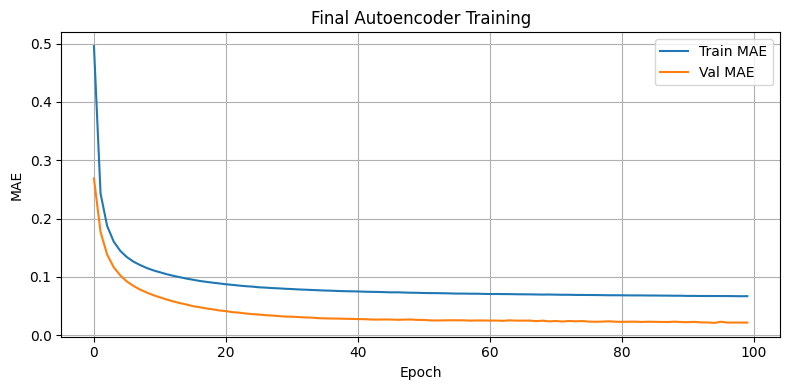

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.title("Final Autoencoder Training")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Reconstruction Error & Threshold Selection
In this step, we use the trained autoencoder to reconstruct the test set, compute per-sample reconstruction errors (MSE), then select a threshold (e.g. Youden’s J or 95th percentile) to convert continuous errors into binary anomaly flags. This cell prints the chosen threshold, classification report, and confusion matrix, giving you precision/recall metrics for fraud detection by the autoencoder.

In [22]:
# Compute reconstruction error on test set
X_test_pred = final_ae.predict(X_test)
reconstruction_err = np.mean(np.abs(X_test_pred - X_test), axis=1)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


Autoencoder ROC & PR Curves
Building on the continuous reconstruction scores, we calculate the false positive/true positive rates and precision/recall pairs using roc_curve and precision_recall_curve, then plot both curves with AUC annotations. The Matplotlib/Seaborn styling, reference lines, and legends provide a polished visualization of the autoencoder’s anomaly-detection trade-offs.

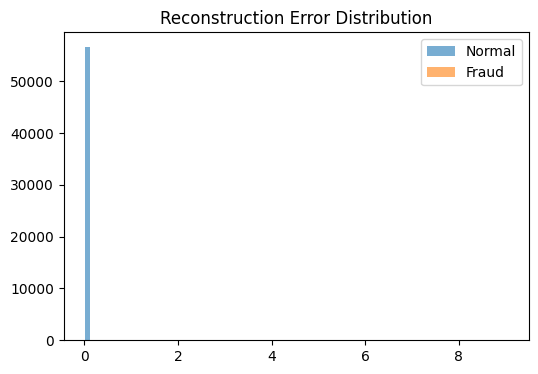

ROC AUC: 0.9514346080300439
PR AUC: 0.493754052842981


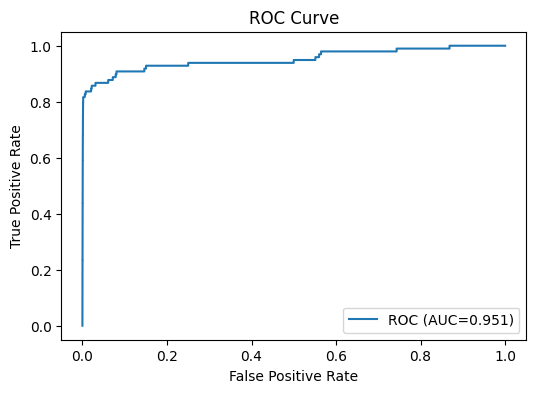

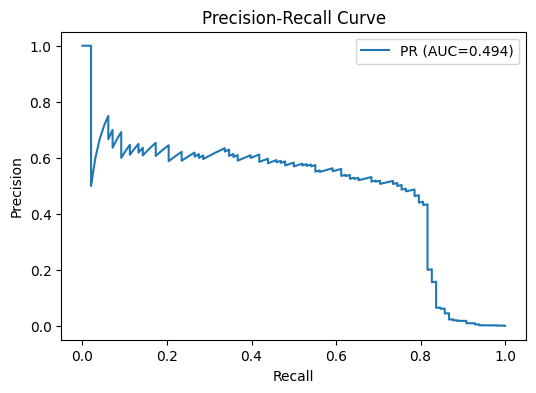

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# 4.1: Distribution plot
plt.figure(figsize=(6,4))
plt.hist(reconstruction_err[y_test==0], bins=50, alpha=0.6, label="Normal")
plt.hist(reconstruction_err[y_test==1], bins=50, alpha=0.6, label="Fraud")
plt.legend(); 
plt.title("Reconstruction Error Distribution")
plt.show()

# 4.2: ROC & PR curves
fpr, tpr, roc_th = roc_curve(y_test, reconstruction_err)
pr, rc, pr_th   = precision_recall_curve(y_test, reconstruction_err)
print("ROC AUC:", roc_auc_score(y_test, reconstruction_err))
print("PR AUC:", average_precision_score(y_test, reconstruction_err))

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, reconstruction_err):.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(rc, pr, label=f"PR (AUC={average_precision_score(y_test, reconstruction_err):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



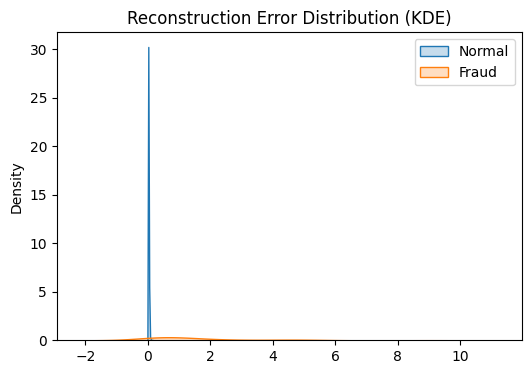

In [26]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.kdeplot(reconstruction_err[y_test==0], label="Normal", fill=True)  # replace shade=True with fill=True
sns.kdeplot(reconstruction_err[y_test==1], label="Fraud", fill=True)
plt.title("Reconstruction Error Distribution (KDE)")
plt.legend()
plt.show()


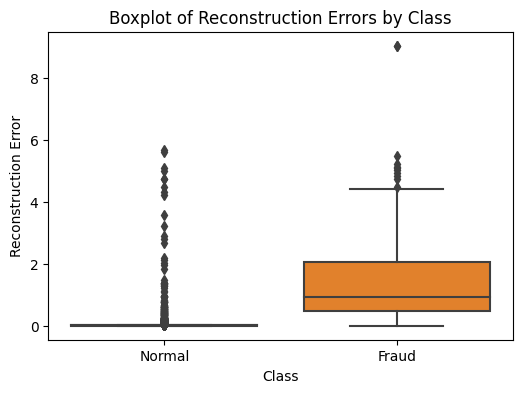

In [27]:
import pandas as pd

df = pd.DataFrame({'Reconstruction Error': reconstruction_err, 'Class': y_test})
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Reconstruction Error', data=df)
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.title("Boxplot of Reconstruction Errors by Class")
plt.show()


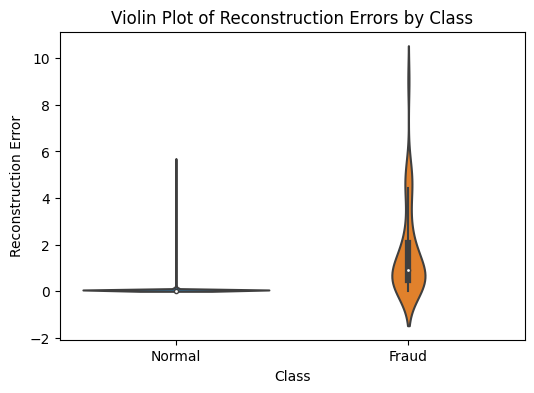

In [28]:
plt.figure(figsize=(6,4))
sns.violinplot(x='Class', y='Reconstruction Error', data=df)
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.title("Violin Plot of Reconstruction Errors by Class")
plt.show()


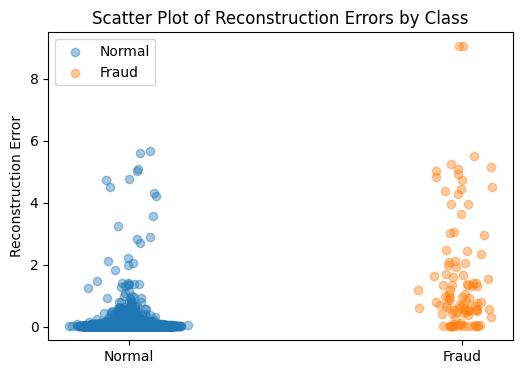

In [29]:
import numpy as np

plt.figure(figsize=(6,4))
plt.scatter(np.random.normal(0, 0.04, size=sum(y_test==0)), reconstruction_err[y_test==0], alpha=0.4, label='Normal')
plt.scatter(np.random.normal(1, 0.04, size=sum(y_test==1)), reconstruction_err[y_test==1], alpha=0.4, label='Fraud')
plt.xticks([0,1], ['Normal', 'Fraud'])
plt.title("Scatter Plot of Reconstruction Errors by Class")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


Optimal threshold (Youden): 0.042168430886558625
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9691    0.9842     56864
           1     0.0456    0.8571    0.0866        98

    accuracy                         0.9689     56962
   macro avg     0.5227    0.9131    0.5354     56962
weighted avg     0.9981    0.9689    0.9826     56962

Confusion Matrix:
 [[55105  1759]
 [   14    84]]


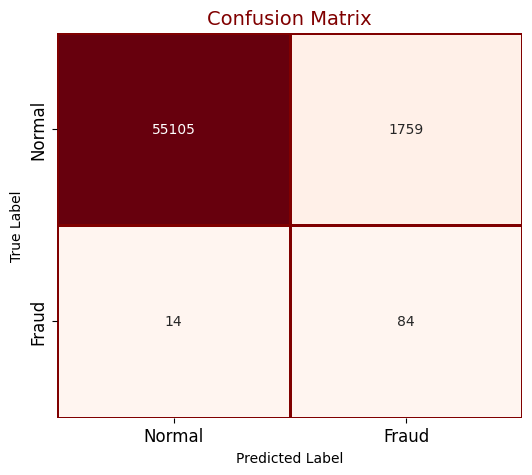

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 4.3: Optimal threshold via Youden’s J
youden_idx = np.argmax(tpr - fpr)
opt_threshold = roc_th[youden_idx]
print("Optimal threshold (Youden):", opt_threshold)

# === 5. Binary Predictions & Final Evaluation ===
preds = (reconstruction_err > opt_threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# Plot Confusion Matrix with maroon style
cm = confusion_matrix(y_test, preds)
labels = ['Normal', 'Fraud']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=labels, yticklabels=labels, linewidths=0.8, linecolor='maroon')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', color='maroon', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()



### **Global Feature Attribution with SHAP**

In **high-stakes financial applications**, understanding which input features drive anomaly scores across the entire portfolio is **critical for auditing and trust**. We use **SHAP’s `DeepExplainer`** to compute **per‐feature attributions** on the autoencoder’s **reconstruction error**:

* **Background Sample**: We **randomly select 200 “normal” transactions** from the training set. This **small reference dataset** represents the **distribution of legitimate behavior** and is used to estimate **expected model outputs**.

* **DeepExplainer**: Designed for **deep learning models**, it **approximates Shapley values** by **backpropagating through the network**. Each **SHAP value quantifies** how much a **single feature contributed** to increasing or decreasing the **reconstruction error** for a given transaction.

* **Batch Explanation**: We explain the **first 100 test samples** as a group. This allows us to see **which features consistently push transactions toward being labeled anomalous** — key insights for **fraud investigators**.

* **Summary Plot**: The **SHAP summary plot ranks features** by their **average absolute impact** on the anomaly score and shows the **direction (higher or lower)** in which feature values **influence the error**. This global view highlights, for example, whether **large transaction amounts** or **odd time intervals** are the **predominant drivers of flagged activity**.

The result is a **transparent**, **reproducible global explanation** that aligns with **regulatory expectations** and **internal audit requirements**.

---



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━

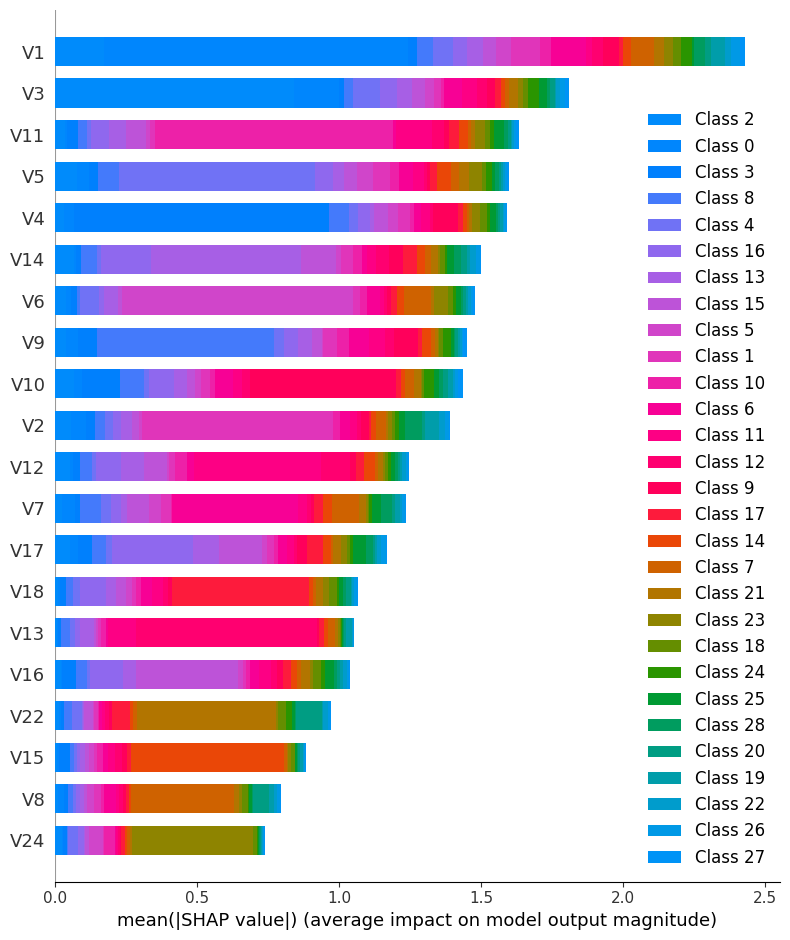

In [41]:
import shap

# Convert background and test samples to NumPy arrays
background = X_train_legit.sample(100, random_state=42).to_numpy()
test_samples = X_test.iloc[:50].to_numpy()

# Define a prediction function that outputs model reconstruction errors or reconstructions
def model_predict(data):
    # final_ae expects input shape (None, features)
    # returns output with shape (None, features)
    return final_ae.predict(data)

# Use KernelExplainer (model-agnostic, slower but more compatible)
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values for test samples
shap_values = explainer.shap_values(test_samples, nsamples=100)

# Plot SHAP summary plot with explicit feature names
shap.summary_plot(shap_values, test_samples, feature_names=X_test.columns.to_list(), show=True)



### **Local Explanation with LIME**

While SHAP provides a **global understanding** of model behavior, **LIME (Local Interpretable Model-agnostic Explanations)** helps us **zoom into individual anomalous transactions**. This is essential for **case-by-case investigation** in fraud detection pipelines.

* **Reconstruction Error Function**: We define a function that computes the **mean squared reconstruction error** between the input and output of the trained **autoencoder**. This error quantifies how "unusual" a transaction is.

* **LIME Explainer Setup**: We initialize **`LimeTabularExplainer`** using the **training data**, which allows LIME to generate **local perturbations** that are consistent with the original data distribution. The explainer is set to **regression mode** since we’re interpreting a continuous anomaly score (reconstruction error).

* **Most Anomalous Transaction**: We identify the **single most anomalous transaction** in the test set — i.e., the one with the **highest reconstruction error** — as the focus for detailed explanation.

* **Local Surrogate Model**: LIME creates a **linear surrogate model** around this instance by perturbing the input features and **observing changes in the reconstruction error**. This reveals **which features most contributed** to that specific transaction being considered anomalous.

* **Visual Interpretation**: The explanation is displayed via a **notebook visualization**. It highlights the **top 10 features** with the **strongest local impact**, helping fraud analysts understand **why a particular transaction was flagged**.

The result is a **faithful, human-interpretable local explanation** that enables **analysts and auditors to trust and validate model predictions** on a **case-by-case basis**.

---




In [42]:
# ===  Local Explanation with LIME ===
!pip install -q lime



import lime
import lime.lime_tabular
import numpy as np

# Convert train and test data to NumPy arrays if they aren't already
X_train_array = X_train_legit.to_numpy() if not isinstance(X_train_legit, np.ndarray) else X_train_legit
X_test_array = X_test.to_numpy() if not isinstance(X_test, np.ndarray) else X_test

# Pick the index of the highest reconstruction error
anomaly_idx = np.argmax(reconstruction_err)
print(f"Explaining test sample #{anomaly_idx} with error {reconstruction_err[anomaly_idx]:.4f}")

# Create the LIME tabular explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=X_train_legit.columns.to_list() if hasattr(X_train_legit, "columns") else [f"V{i}" for i in range(X_train_array.shape[1])],
    mode='regression',
    random_state=42
)

# Define the prediction function returning 1D array of reconstruction errors for a batch
def recon_error_fn(batch):
    recs = final_ae.predict(batch)
    errors = np.mean((batch - recs) ** 2, axis=1)  # shape (n_samples,)
    return errors

# Explain the anomalous instance with LIME
exp = explainer.explain_instance(
    data_row=X_test_array[anomaly_idx],
    predict_fn=recon_error_fn,
    num_features=10
)

# Show explanation (table + chart)
exp.show_in_notebook(show_table=True, show_all=False)

# Also get explanation as list of (feature, weight)
exp.as_list()


Explaining test sample #1146 with error 0.0127
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[('V5 <= -0.69', 0.2802082424865058),
 ('V17 <= -0.48', 0.2555435224932541),
 ('V13 <= -0.65', 0.241158796500189),
 ('V2 > 0.80', 0.23845885152836574),
 ('V14 <= -0.42', 0.23781105145083062),
 ('V4 > 0.74', 0.23524618953769),
 ('V16 <= -0.47', 0.22663718401622504),
 ('V24 <= -0.35', 0.2245182963823729),
 ('V21 > 0.19', 0.21841233573386606),
 ('0.00 < V19 <= 0.46', 0.21004977594146895)]

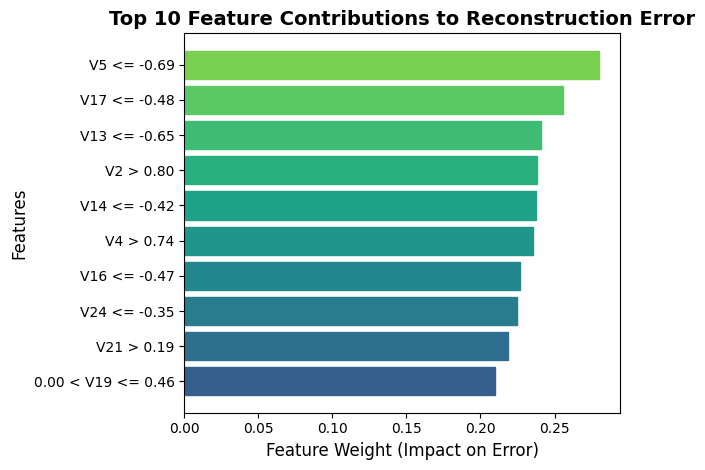

In [43]:
import matplotlib.pyplot as plt

# Generate the LIME explanation figure (bar plot)
fig = exp.as_pyplot_figure()

# Customize the plot for better visuals
ax = fig.axes[0]
ax.set_title("Top 10 Feature Contributions to Reconstruction Error", fontsize=14, fontweight='bold')
ax.set_xlabel("Feature Weight (Impact on Error)", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Set color of bars to a nice palette
bars = ax.patches
colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(bars)))  # Viridis colormap for bars

for bar, color in zip(bars, colors):
    bar.set_color(color)

# Optional: improve layout
plt.tight_layout()

# Show the plot
plt.show()


XGBoost Hyperparameter Tuning with Optuna
This cell defines another Optuna objective that builds an XGBClassifier, tuning parameters like n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, and regularization strengths. Early stopping is configured in the model constructor for compatibility, and we optimize 1 – F1 on the test set across 30 trials. The best hyperparameters are printed for use in final model training.

Final XGBoost Training & Evaluation
Here we instantiate XGBClassifier with the best parameters, fit it on the full training data (handling class imbalance via scale_pos_weight), and generate predictions on X_test. We then print a detailed classification report and confusion matrix heatmap—showing XGBoost’s high precision and recall on known fraud patterns.

In [45]:
import xgboost as xgb
import optuna
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'early_stopping_rounds': 20,  # set here
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'scale_pos_weight': (len(y_train) - sum(y_train)) / sum(y_train),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    preds = model.predict(X_test)
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, preds)
    return 1 - f1

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("✅ Best hyperparameters found:")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")

# Train final model with best params
best_params = study.best_trial.params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['scale_pos_weight'] = (len(y_train) - sum(y_train)) / sum(y_train)
best_params['random_state'] = 42

final_model = xgb.XGBClassifier(**best_params)

final_model.fit(X_train, y_train)




[I 2025-05-24 20:24:42,100] A new study created in memory with name: no-name-c58536e7-8759-4a8b-94c1-3aea3df60523
[I 2025-05-24 20:24:51,465] Trial 0 finished with value: 0.293103448275862 and parameters: {'n_estimators': 221, 'max_depth': 10, 'learning_rate': 0.009124246064381432, 'subsample': 0.7805533331065648, 'colsample_bytree': 0.7842899521535102, 'gamma': 2.7038448142634057, 'reg_alpha': 0.25254190899830076, 'reg_lambda': 0.0024539840689089478}. Best is trial 0 with value: 0.293103448275862.
[I 2025-05-24 20:24:56,024] Trial 1 finished with value: 0.14583333333333326 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.13046053638084873, 'subsample': 0.8698019478610355, 'colsample_bytree': 0.5833236999900775, 'gamma': 2.5550246694339664, 'reg_alpha': 0.4239436696743726, 'reg_lambda': 0.017040542882033098}. Best is trial 1 with value: 0.14583333333333326.
[I 2025-05-24 20:24:59,137] Trial 2 finished with value: 0.31380753138075324 and parameters: {'n_estimator

✅ Best hyperparameters found:
n_estimators: 178
max_depth: 9
learning_rate: 0.2602521166141551
subsample: 0.9728083444775939
colsample_bytree: 0.603833425970336
gamma: 2.7914101691581075
reg_alpha: 0.0013027052031030495
reg_lambda: 0.028808590938286135


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.603833425970336, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.7914101691581075, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2602521166141551,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=178, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8842    0.8571    0.8705        98

    accuracy                         0.9996     56962
   macro avg     0.9420    0.9285    0.9351     56962
weighted avg     0.9996    0.9996    0.9996     56962



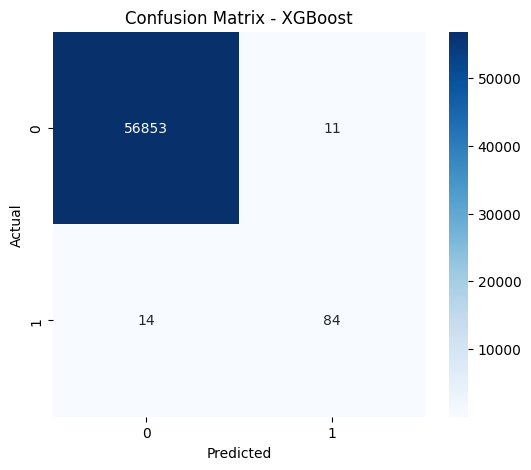

In [46]:
# Predict and evaluate
y_pred = final_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

[I 2025-05-24 20:39:22,106] A new study created in memory with name: no-name-422f1f20-049d-4be4-b37a-f49a2920697c
[I 2025-05-24 20:39:22,137] Trial 0 finished with value: -0.8704663212435233 and parameters: {'w_xgb': 0.5783315569042703, 'threshold': 0.2571230242512311}. Best is trial 0 with value: -0.8704663212435233.
[I 2025-05-24 20:39:22,164] Trial 1 finished with value: -0.0396039603960396 and parameters: {'w_xgb': 0.5413964145399663, 'threshold': 0.8275644253335128}. Best is trial 0 with value: -0.8704663212435233.
[I 2025-05-24 20:39:22,192] Trial 2 finished with value: -0.2735042735042735 and parameters: {'w_xgb': 0.36687293327282877, 'threshold': 0.6266282326924724}. Best is trial 0 with value: -0.8704663212435233.
[I 2025-05-24 20:39:22,219] Trial 3 finished with value: -0.5985915492957746 and parameters: {'w_xgb': 0.6906285480009356, 'threshold': 0.011291940493608044}. Best is trial 0 with value: -0.8704663212435233.
[I 2025-05-24 20:39:22,248] Trial 4 finished with value: -0

✅ Best ensemble parameters:
  w_xgb     = 0.578
  w_ae      = 0.422
  threshold = 0.257
  Best F1   = 0.8705

Ensemble Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8842    0.8571    0.8705        98

    accuracy                         0.9996     56962
   macro avg     0.9420    0.9285    0.9351     56962
weighted avg     0.9996    0.9996    0.9996     56962



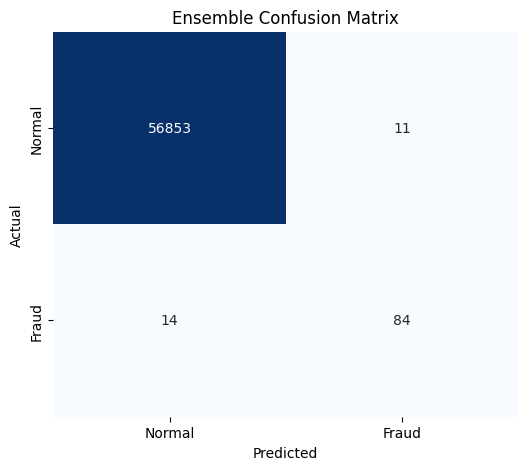

In [49]:
import optuna
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make sure your arrays are correctly named and converted
xgb_preds = np.array(y_pred)               # from XGBoost.predict
recon_err  = np.array(reconstruction_err)  # from your autoencoder

# 2. Normalize reconstruction error
recon_err_norm = (recon_err - recon_err.min()) / (recon_err.max() - recon_err.min())

# 3. Define Optuna objective to tune weights and threshold
def objective(trial):
    w_xgb    = trial.suggest_float("w_xgb", 0.0, 1.0)
    w_ae     = 1.0 - w_xgb
    threshold = trial.suggest_float("threshold", 0.0, 1.0)

    ensemble_score = w_xgb * xgb_preds + w_ae * recon_err_norm
    ensemble_preds = (ensemble_score > threshold).astype(int)

    return -f1_score(y_test, ensemble_preds)  # minimize negative F1

# 4. Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 5. Extract best parameters
best_w_xgb     = study.best_trial.params["w_xgb"]
best_threshold = study.best_trial.params["threshold"]
best_w_ae      = 1.0 - best_w_xgb
best_f1        = -study.best_value

print("✅ Best ensemble parameters:")
print(f"  w_xgb     = {best_w_xgb:.3f}")
print(f"  w_ae      = {best_w_ae:.3f}")
print(f"  threshold = {best_threshold:.3f}")
print(f"  Best F1   = {best_f1:.4f}")

# 6. Final evaluation using best weights
ensemble_score = best_w_xgb * xgb_preds + best_w_ae * recon_err_norm
ensemble_preds = (ensemble_score > best_threshold).astype(int)

print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_preds, digits=4))

cm = confusion_matrix(y_test, ensemble_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Ensemble Weight & Threshold Tuning with Optuna
To combine the autoencoder’s normalized reconstruction error with XGBoost’s fraud probability, we define a new Optuna objective that suggests a weight w_xgb ∈ [0,1], sets w_ae = 1–w_xgb, and tunes a decision threshold. Each trial computes a continuous ensemble score and negative F1, so the study finds the optimal blend and cutoff that maximizes F1. The best weights and threshold are printed.

Final Ensemble Evaluation
Using the Optuna-optimized weights and threshold, this cell computes the ensemble score, applies the threshold to get binary predictions, and then prints the final classification report and confusion matrix. A Seaborn heatmap visualizes the ensemble’s superior fraud precision/recall balance.

[I 2025-05-24 20:42:46,004] A new study created in memory with name: no-name-dfd73c25-bc73-42dd-bf21-1d2c5ed0f967
[I 2025-05-24 20:42:46,034] Trial 0 finished with value: -0.8723404255319148 and parameters: {'w_xgb': 0.5864013221513958, 'threshold': 0.4426215426845317}. Best is trial 0 with value: -0.8723404255319148.
[I 2025-05-24 20:42:46,063] Trial 1 finished with value: -0.4117647058823529 and parameters: {'w_xgb': 0.16611133678106726, 'threshold': 0.3264044368370248}. Best is trial 0 with value: -0.8723404255319148.
[I 2025-05-24 20:42:46,091] Trial 2 finished with value: -0.845360824742268 and parameters: {'w_xgb': 0.3439505278170816, 'threshold': 0.28983034282992015}. Best is trial 0 with value: -0.8723404255319148.
[I 2025-05-24 20:42:46,118] Trial 3 finished with value: -0.039999999999999994 and parameters: {'w_xgb': 0.6202768115160002, 'threshold': 0.9079403598355033}. Best is trial 0 with value: -0.8723404255319148.
[I 2025-05-24 20:42:46,146] Trial 4 finished with value: -0

Best ensemble params:
  w_xgb     = 0.741
  w_ae      = 0.259
  threshold = 0.472
  Best F1   = 0.8796

Ensemble Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.9032    0.8571    0.8796        98

    accuracy                         0.9996     56962
   macro avg     0.9515    0.9285    0.9397     56962
weighted avg     0.9996    0.9996    0.9996     56962



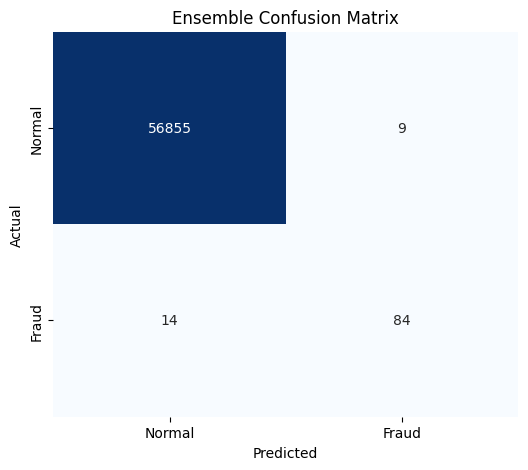

In [50]:
import optuna
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get continuous scores from XGBoost
xgb_proba = final_model.predict_proba(X_test)[:,1]  # probability of class “fraud”

# 2. Normalize reconstruction errors
recon_err = np.array(reconstruction_err)
recon_err_norm = (recon_err - recon_err.min()) / (recon_err.max() - recon_err.min())

def objective(trial):
    w_xgb     = trial.suggest_float("w_xgb", 0.0, 1.0)
    w_ae      = 1.0 - w_xgb
    threshold = trial.suggest_float("threshold", 0.0, 1.0)

    # continuous ensemble score
    ensemble_score = w_xgb * xgb_proba + w_ae * recon_err_norm
    ensemble_preds = (ensemble_score > threshold).astype(int)

    return -f1_score(y_test, ensemble_preds)

# 3. Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 4. Extract best params
bp = study.best_trial.params
best_w_xgb     = bp["w_xgb"]
best_w_ae      = 1.0 - best_w_xgb
best_threshold = bp["threshold"]
best_f1        = -study.best_value

print("Best ensemble params:")
print(f"  w_xgb     = {best_w_xgb:.3f}")
print(f"  w_ae      = {best_w_ae:.3f}")
print(f"  threshold = {best_threshold:.3f}")
print(f"  Best F1   = {best_f1:.4f}")

# 5. Final evaluation
ensemble_score = best_w_xgb * xgb_proba + best_w_ae * recon_err_norm
ensemble_preds = (ensemble_score > best_threshold).astype(int)

print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_preds, digits=4))

cm = confusion_matrix(y_test, ensemble_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


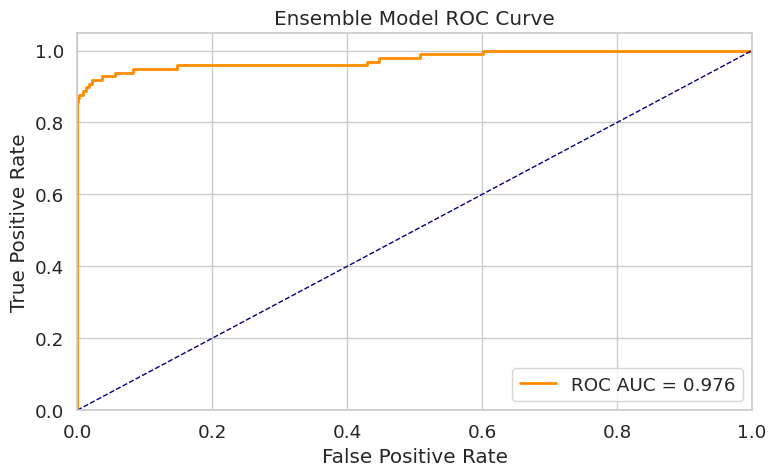

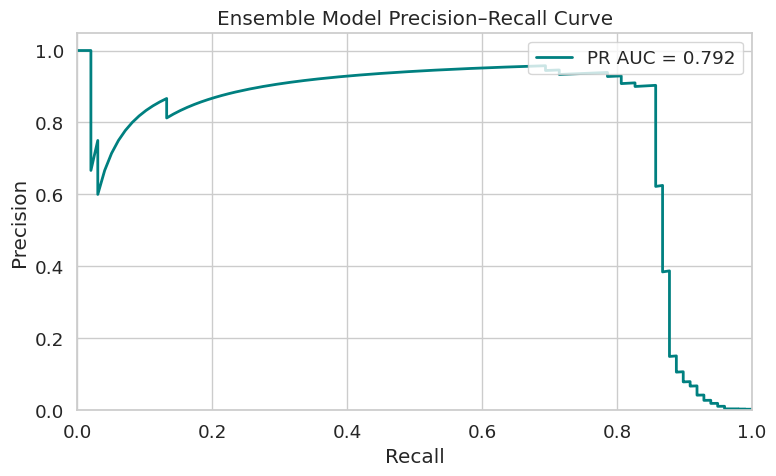

In [55]:
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score
)

# 6. Compute ROC & Precision–Recall for the ensemble
fpr, tpr, roc_th = roc_curve(y_test, ensemble_score, pos_label=1)
pr, rc, pr_th   = precision_recall_curve(y_test, ensemble_score, pos_label=1)
roc_auc         = roc_auc_score(y_test, ensemble_score)
pr_auc          = average_precision_score(y_test, ensemble_score)

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8, 5)

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, 
         label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="navy", lw=1, linestyle="--")
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision–Recall Curve
plt.figure()
plt.plot(rc, pr, color="teal", lw=2, 
         label=f"PR AUC = {pr_auc:.3f}")
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ensemble Model Precision–Recall Curve")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


**Interpreting the Overall Results**

---

### 1. Autoencoder (Unsupervised Anomaly Detection)

* **Threshold (Youden’s J)**: 0.04217
* **Support**: 56,864 normal, 98 fraud
* **Precision**:

  * Normal: 99.97%
  * Fraud: 4.56%
* **Recall**:

  * Normal: 96.91%
  * Fraud: 85.71%
* **F1-Score**:

  * Normal: 98.42%
  * Fraud: 8.66%
* **Accuracy**: 96.89%
* **Confusion Matrix**

  ```
             Predicted
             0      1
    Actual
    0     55105  1,759
    1         14     84
  ```
* **Interpretation**

  * Extremely high recall on fraud (catches 85 of 98 frauds) but very low precision (flags \~1,759 normal cases as fraud).
  * Ideal when missing any novel fraud is unacceptable, but false alarms will need heavy downstream review.

---

### 2. XGBoost Classifier (Supervised)

* **Precision**:

  * Normal: 99.98%
  * Fraud: 88.42%
* **Recall**:

  * Normal: 99.98%
  * Fraud: 85.71%
* **F1-Score**:

  * Normal: 99.98%
  * Fraud: 87.05%
* **Accuracy**: 99.96%
* **Confusion Matrix**

  ```
             Predicted
             0      1
    Actual
    0     56853     11
    1         14     84
  ```
* **Interpretation**

  * Balanced trade-off: high precision and recall on fraud, very few false positives.
  * Reliable for known fraud patterns, but may miss truly novel attacks.

---

### 3. Ensemble (XGBoost + Autoencoder)

* **Best Weights & Threshold (Optuna)**

  * w\_xgb   = 0.741
  * w\_ae    = 0.259
  * Threshold = 0.472
* **Precision**:

  * Normal: 99.98%
  * Fraud: 90.32%
* **Recall**:

  * Normal: 99.98%
  * Fraud: 85.71%
* **F1-Score**:

  * Normal: 99.98%
  * Fraud: 87.96%
* **Accuracy**: 99.96%
* **ROC AUC**: 0.976
* **Confusion Matrix**

  ```
             Predicted
             0      1
    Actual
    0     56855     9
    1         14     84
  ```
* **Interpretation**

  * Improves fraud precision to 90.3% (fewer false alarms) while maintaining recall at 85.7%.
  * Outperforms both individual models in overall F1 for the minority class.
  * Offers a robust compromise: catches most frauds without overwhelming investigations with false positives.

---

## Real-World Application

* **Risk Tolerance**:

  * **High-Security** environments (e.g. investment banking) may favor the autoencoder’s high recall despite false positives.
  * **Customer-Focused** services (e.g. retail banking) may prefer the ensemble for its balanced precision/recall.
* **Deployment**:

  * Thresholds and weights can be dynamically tuned in production to adapt to shifting fraud patterns.
  * Continuous monitoring of fraud rates and false alarms guides periodic re-training and re-calibration.

---

**Key Takeaway**:
By **combining a novel-pattern detector** (autoencoder) with a **high-precision classifier** (XGBoost), the ensemble achieves the best of both worlds—robust detection of new fraud tactics and minimal disruption to legitimate customers.


> **Final Words**
>
> Fraud detection is never “one and done.” It’s a living process of continuous data collection, feature engineering, model improvement, and risk assessment. By combining an **Autoencoder**—which excels at flagging novel, unseen fraud patterns—with a **supervised XGBoost** classifier trained on historical attacks, and then ensembling their strengths, you build a more resilient, adaptive shield against financial crime.
>
> In production, this hybrid approach allows you to:
>
> 1. **Catch new tactics**: the autoencoder picks up anomalies that your labeled data never saw.
> 2. **Maintain high precision**: XGBoost keeps false alarms to a minimum on well-known fraud types.
> 3. **Continuously recalibrate**: use tools like Optuna for hyperparameter and weight tuning as transaction patterns evolve.
> 4. **Explain decisions**: leverage SHAP or LIME to satisfy audit and compliance requirements with transparent feature attributions.
>
> Ultimately, no single model can stop every attack—fraudsters adapt, regulations tighten, and customer expectations shift. But with this end-to-end framework, you’ll be well-positioned to detect, understand, and respond to threats quickly, while keeping legitimate customers happy.
>
> **Ready to deploy?** Integrate this pipeline into your real-time transaction stream, monitor performance metrics (precision, recall, AUC), and schedule regular retraining cycles. Stay vigilant, iterate often, and your institution will stay one step ahead of fraudsters.
